# 1. Library Imports

In [1]:
import scanpy as sc
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import seaborn as sns

# 2. Load Pre-Processed Data

In [2]:
adata = sc.read("../data/processed/pbmc3k_preprocessed.h5ad")
print(adata)
print(adata.shape)

AnnData object with n_obs × n_vars = 2638 × 2013
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'gene_ids', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'
(2638, 2013)


# 3. Visualizations and Annotations

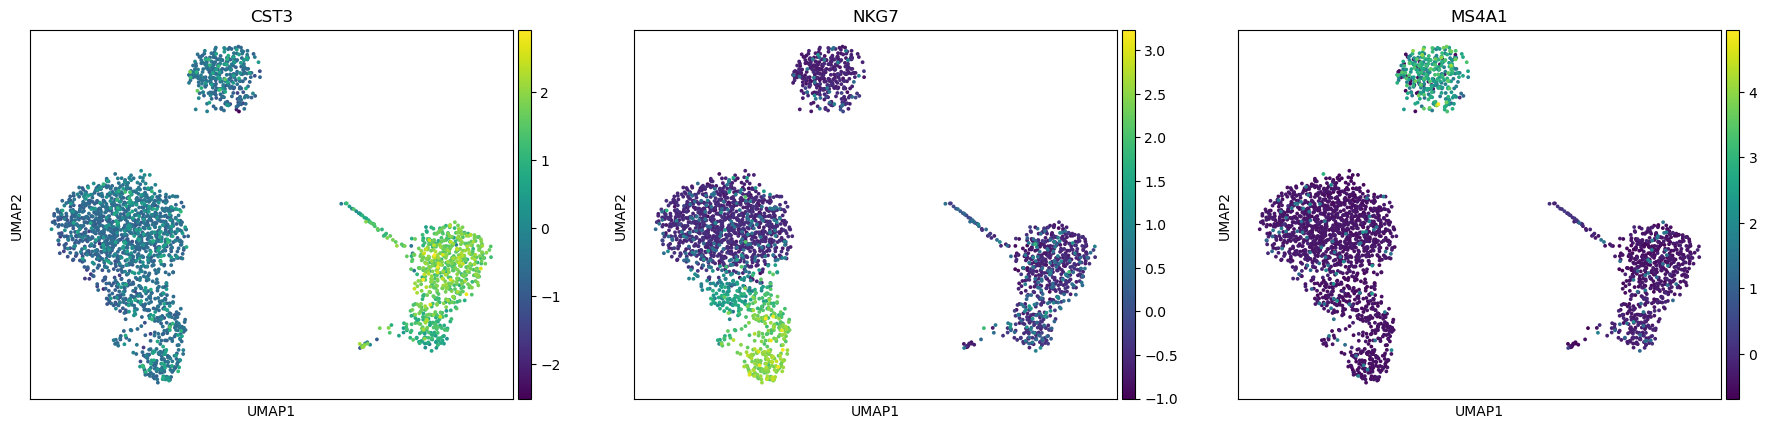

In [3]:
marker_genes = ['CST3', 'NKG7', 'MS4A1']
sc.pl.umap(adata, color=marker_genes, cmap='viridis', size=30)

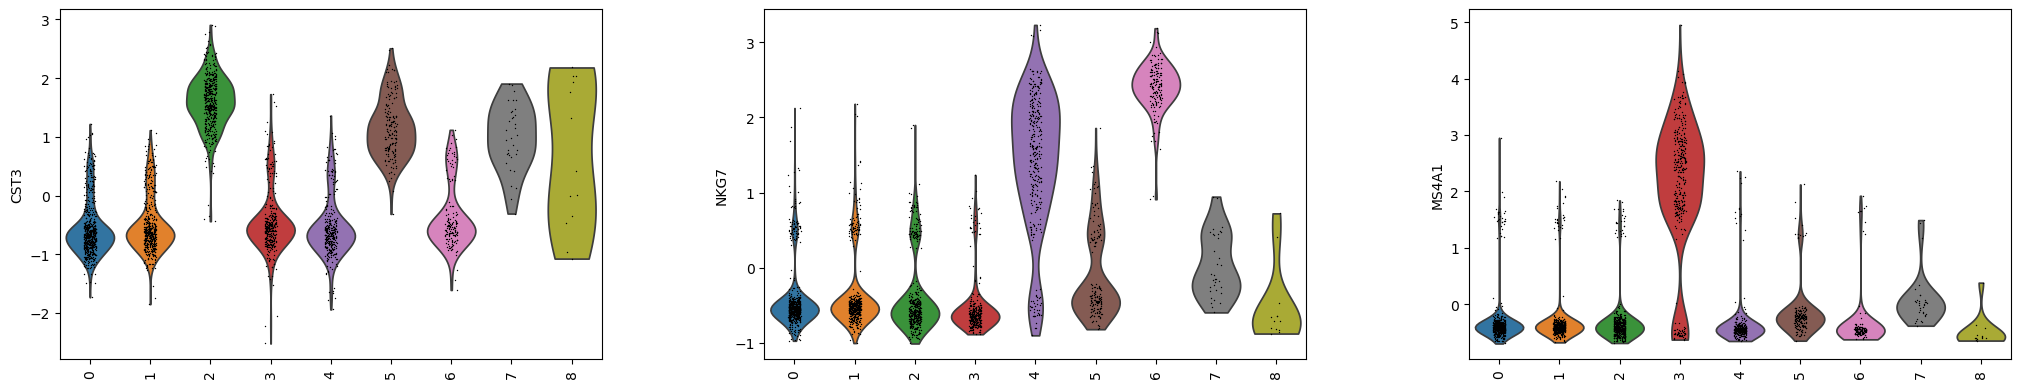

In [4]:
sc.pl.violin(adata, marker_genes, groupby='leiden', rotation=90)

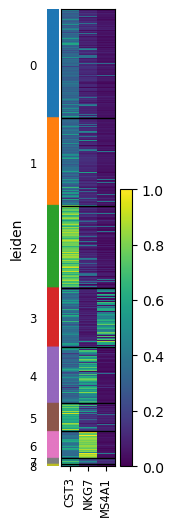

In [5]:
sc.pl.heatmap(adata, var_names=marker_genes, groupby='leiden', standard_scale='var')

In [6]:
cluster_to_celltype = {
    '2': 'Monocytes',  # CST3-high
    '3': 'B cells',    # MS4A1-high
    '6': 'NK cells',   # NKG7-high
}

adata.obs['cell_type'] = adata.obs['leiden'].map(cluster_to_celltype)

adata.obs['cell_type'] = adata.obs['leiden'].map(cluster_to_celltype)

In [7]:
# List of Marker Genes
marker_genes = ['MS4A1','CD19','CD79A','CD3D','CD3E','CD4','CD8A','CD8B','NKG7','NCAM1','GNLY','CST3','CD14','LYZ','FCER1A','CLEC9A','PPBP']

present_markers = [gene for gene in marker_genes if gene in adata.var_names]
print("Markers present in dataset:", present_markers)

Markers present in dataset: ['MS4A1', 'CD19', 'CD79A', 'NKG7', 'GNLY', 'CST3', 'FCER1A', 'PPBP']


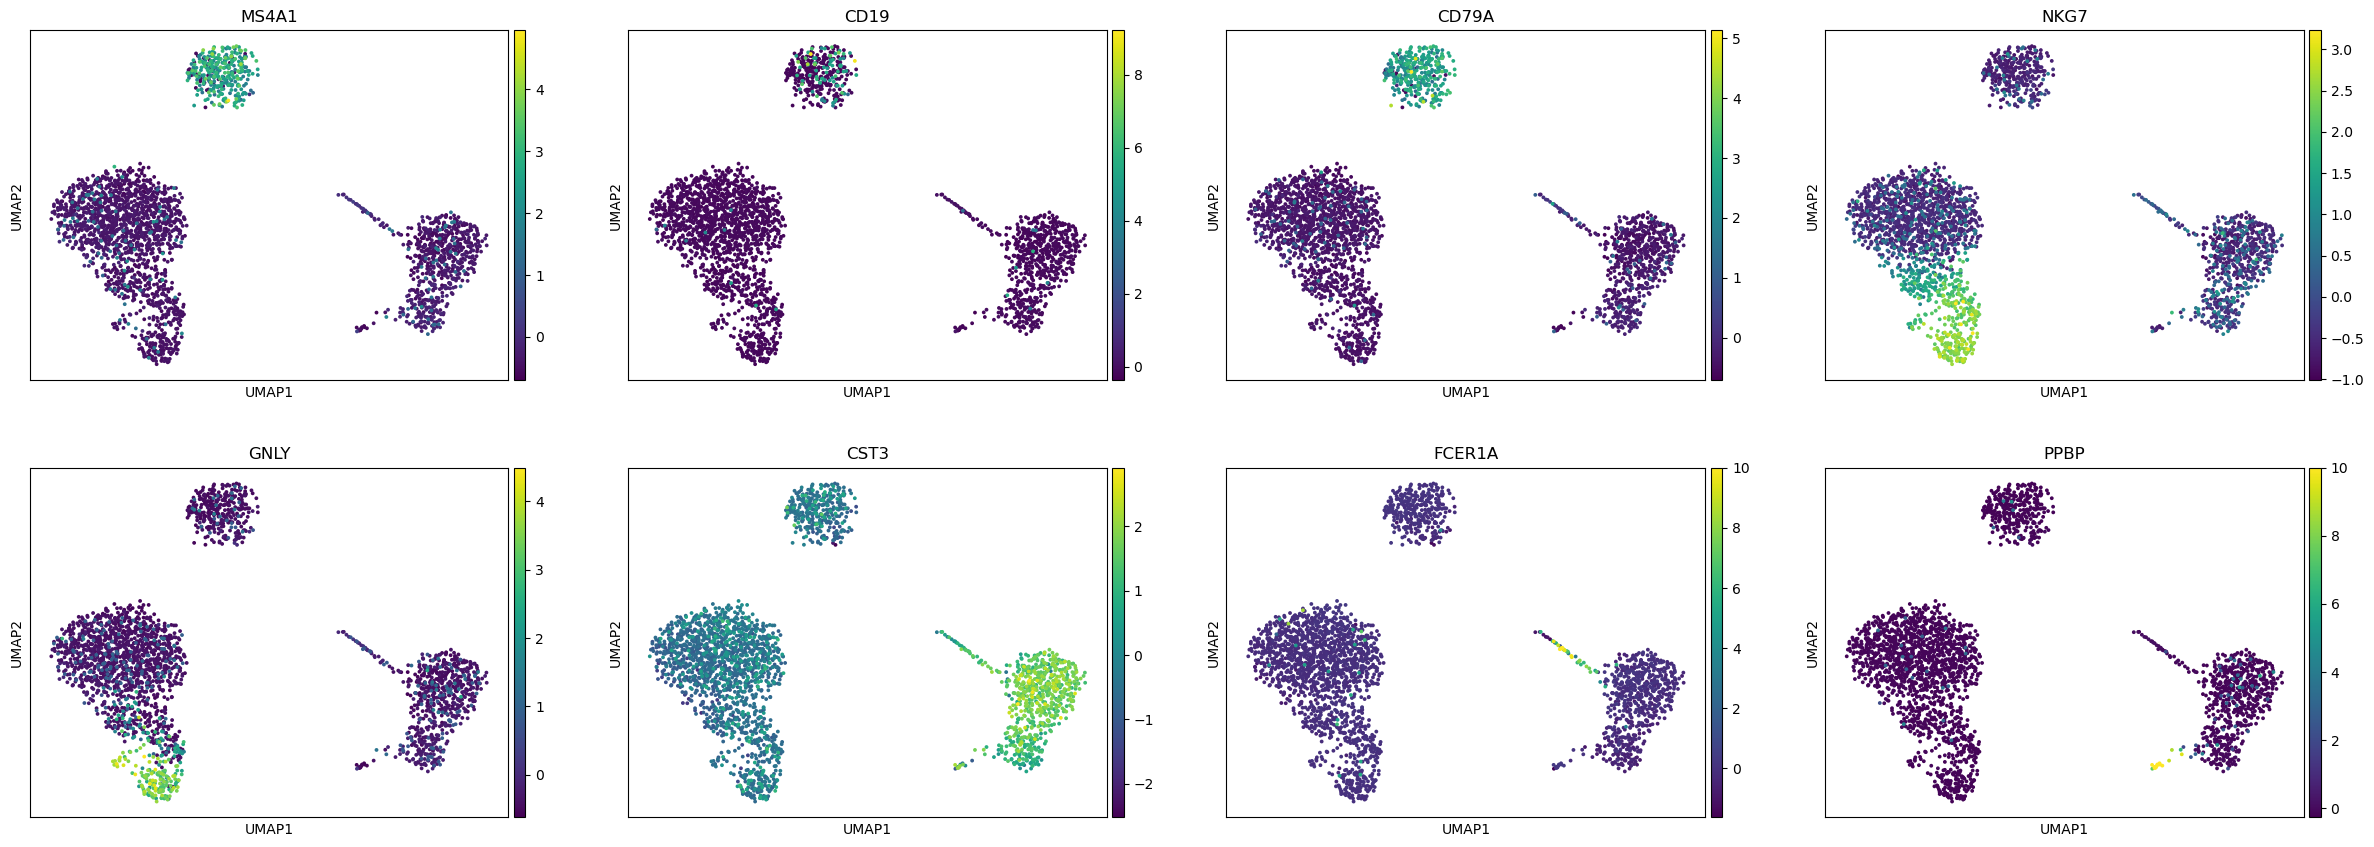

In [8]:
sc.pl.umap(adata, color=present_markers, cmap='viridis', size=30)

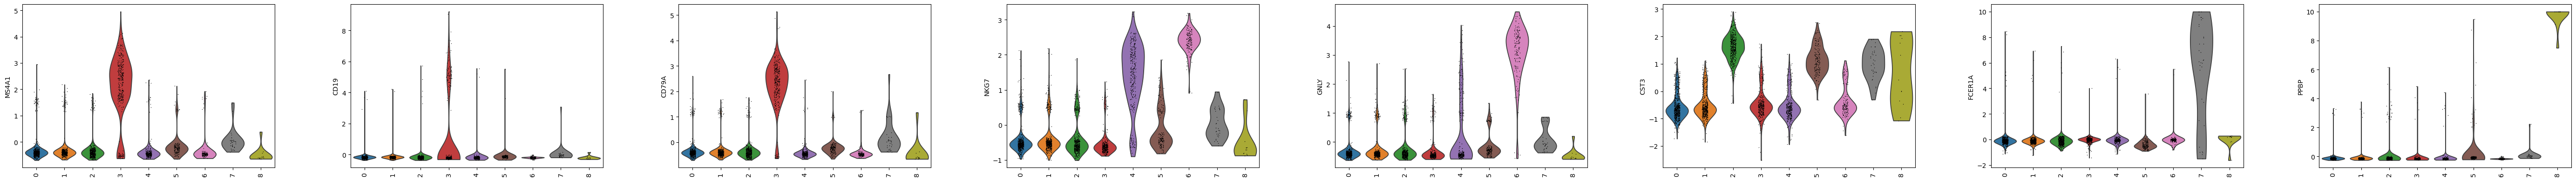

In [9]:
sc.pl.violin(adata, present_markers, groupby='leiden', rotation=90)

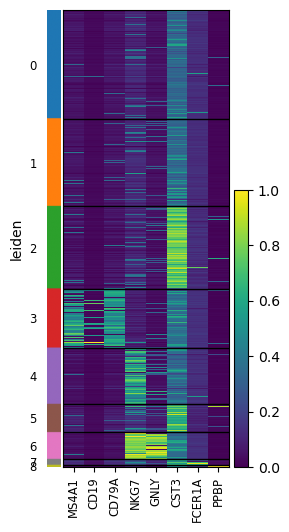

In [10]:
sc.pl.heatmap(adata, var_names=present_markers, groupby='leiden', standard_scale='var')

After performing unsupervised clustering with Leiden Clustering during preprocessing, I annotated the resulting clusters using a **marker gene dictionary** derived from canonical immunology knowledge. Each cluster’s average expression was compared against a curated set of cell type–specific markers, e.g. MS4A1 for B cells, CD3D/CD4 for CD4 T cells, CD3D/CD8A for CD8 T cells, NKG7 for NK cells, CST3/CD14 for monocytes.

In [11]:
# Dictionary of canonical PBMC markers
marker_dict = {
    'B cells': ['MS4A1', 'CD19', 'CD79A'],
    'CD4 T cells': ['CD3D', 'CD3E', 'CD4'],
    'CD8 T cells': ['CD3D', 'CD8A', 'CD8B'],
    'NK cells': ['NKG7', 'NCAM1', 'GNLY'],
    'Monocytes': ['CST3', 'CD14', 'LYZ'],
    'Dendritic cells': ['FCER1A', 'CLEC9A'],
    'Platelets': ['PPBP']
}

for cell_type in marker_dict:
    marker_dict[cell_type] = [gene for gene in marker_dict[cell_type] if gene in adata.var_names]

marker_dict

{'B cells': ['MS4A1', 'CD19', 'CD79A'],
 'CD4 T cells': [],
 'CD8 T cells': [],
 'NK cells': ['NKG7', 'GNLY'],
 'Monocytes': ['CST3'],
 'Dendritic cells': ['FCER1A'],
 'Platelets': ['PPBP']}

In [12]:
def assign_cell_types(adata, cluster_key='leiden', marker_dict=marker_dict):
    cluster_ids = adata.obs[cluster_key].unique()
    cluster_to_celltype = {}
    
    for cluster in cluster_ids:
        cluster_cells = adata[adata.obs[cluster_key] == cluster]
        
        mean_expr = {}
        for cell_type, markers in marker_dict.items():
            if len(markers) == 0:
                continue
            mean_expr[cell_type] = cluster_cells[:, markers].X.mean()
        
        if mean_expr:
            assigned_type = max(mean_expr, key=mean_expr.get)
            cluster_to_celltype[cluster] = assigned_type
        else:
            cluster_to_celltype[cluster] = 'Unknown'
    
    adata.obs['cell_type'] = adata.obs[cluster_key].map(cluster_to_celltype)
    
    return cluster_to_celltype

In [13]:
cluster_mapping = assign_cell_types(adata)
print(cluster_mapping)

{'0': 'Dendritic cells', '3': 'B cells', '1': 'Dendritic cells', '5': 'Monocytes', '6': 'NK cells', '4': 'NK cells', '2': 'Monocytes', '7': 'Dendritic cells', '8': 'Platelets'}


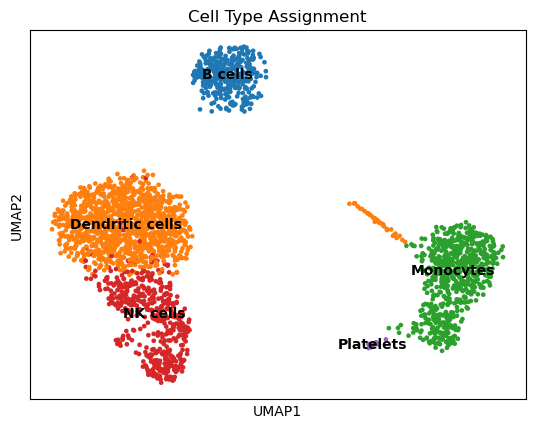

In [14]:
sc.pl.umap(adata, color=['cell_type'], legend_loc='on data', title='Cell Type Assignment')

# 4. Classification

In [15]:
X = adata[:, adata.var["highly_variable"]].X.toarray()
y = adata.obs["cell_type"].values

class_names = np.unique(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [16]:
# Helper Functions

def eval_and_print(model, X_test, y_test, class_names, name="Model"):
    y_pred = model.predict(X_test)
    print(f"=== {name} ===")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred, labels=class_names)
    return y_pred, cm

def plot_cm(cm, class_names, title):
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.show()

## Logistic Regression

=== Logistic Regression ===
Accuracy: 0.9545454545454546


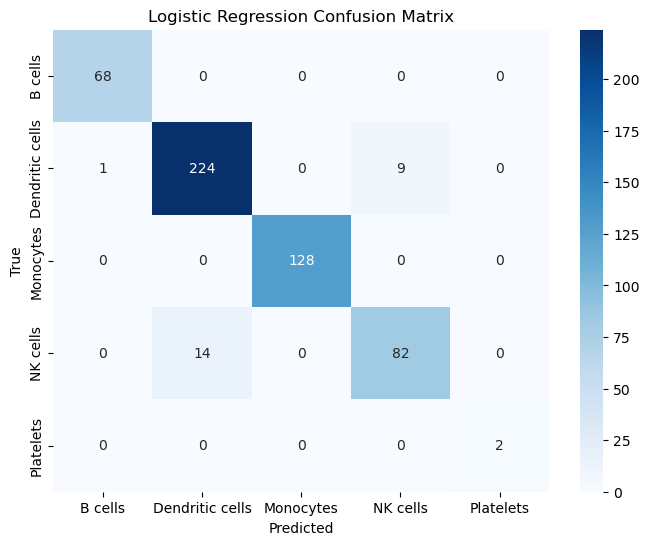

In [17]:
lr = LogisticRegression(max_iter=10000, solver='saga', n_jobs=-1)
lr.fit(X_train, y_train)
y_pred_lr, cm_lr = eval_and_print(lr, X_test, y_test, class_names, "Logistic Regression")
plot_cm(cm_lr, class_names, "Logistic Regression Confusion Matrix")

## Random Forest

=== Random Forest ===
Accuracy: 0.9526515151515151


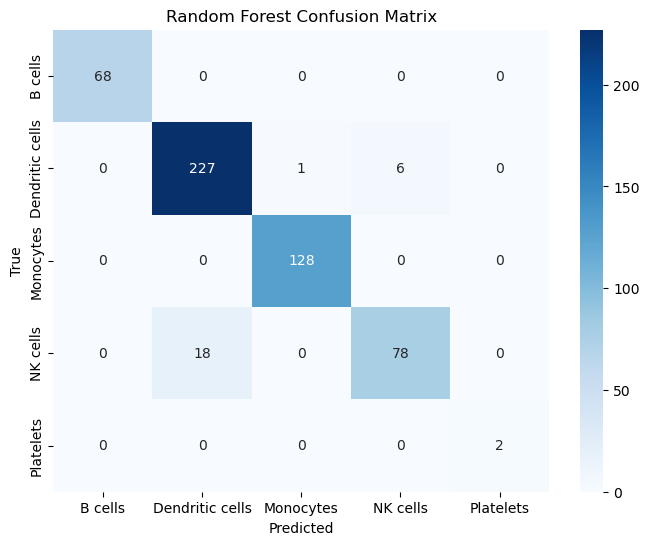

In [18]:
rf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred_rf, cm_rf = eval_and_print(rf, X_test, y_test, class_names, "Random Forest")
plot_cm(cm_rf, class_names, "Random Forest Confusion Matrix")

## Neural Network

In [19]:
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(pd.Categorical(y_train).codes, dtype=torch.long)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(pd.Categorical(y_test).codes, dtype=torch.long)

train_ds = TensorDataset(X_train_t, y_train_t)
test_ds = TensorDataset(X_test_t, y_test_t)
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=64)

In [20]:
class CellClassifier(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 5)
        )
    def forward(self, x):
        return self.network(x)

# Train the Model
model = CellClassifier(input_dim=X_train.shape[1])
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 100
batch_size = 16

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    correct_preds = 0
    total_preds = 0
    
    for batch_X, batch_T in train_dl:
        outputs = model(batch_X)
        loss = criterion(outputs, batch_T)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * batch_X.size(0)

        _, preds = torch.max(outputs, 1)
        correct_preds += (preds == batch_T).sum().item()
        total_preds += batch_T.size(0)

    avg_loss = epoch_loss / len(train_ds)
    accuracy = correct_preds / total_preds

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}] "
              f"Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")

Epoch [10/100] Loss: 0.0002, Accuracy: 1.0000
Epoch [20/100] Loss: 0.0001, Accuracy: 1.0000
Epoch [30/100] Loss: 0.0000, Accuracy: 1.0000
Epoch [40/100] Loss: 0.0000, Accuracy: 1.0000
Epoch [50/100] Loss: 0.0000, Accuracy: 1.0000
Epoch [60/100] Loss: 0.0000, Accuracy: 1.0000
Epoch [70/100] Loss: 0.0000, Accuracy: 1.0000
Epoch [80/100] Loss: 0.0000, Accuracy: 1.0000
Epoch [90/100] Loss: 0.0000, Accuracy: 1.0000
Epoch [100/100] Loss: 0.0000, Accuracy: 1.0000


Test Loss: 0.3339, Test Accuracy: 0.9545

Classification Report:
                 precision    recall  f1-score   support

        B cells       1.00      1.00      1.00        68
Dendritic cells       0.94      0.95      0.95       234
      Monocytes       0.98      1.00      0.99       128
       NK cells       0.90      0.86      0.88        96
      Platelets       1.00      1.00      1.00         2

       accuracy                           0.95       528
      macro avg       0.97      0.96      0.96       528
   weighted avg       0.95      0.95      0.95       528

Confusion Matrix:


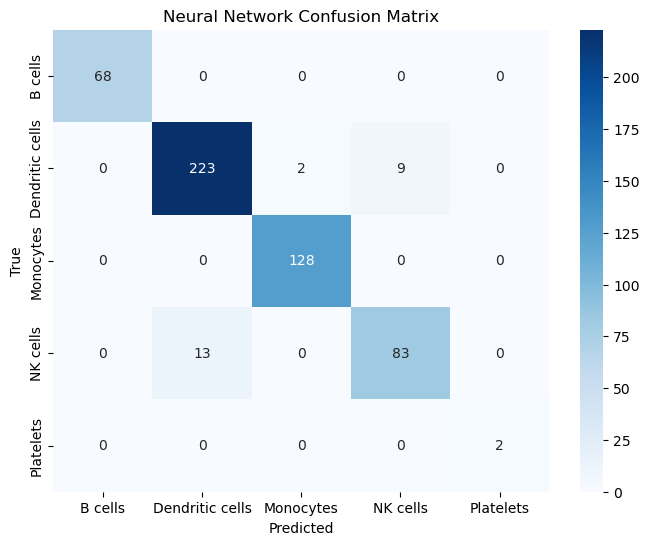

In [21]:
def evaluate(model, test_dl, criterion, class_names=None):
    model.eval()
    test_loss = 0.0
    correct_preds = 0
    total_preds = 0

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch_X, batch_T in test_dl:
            outputs = model(batch_X)
            loss = criterion(outputs, batch_T)

            test_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct_preds += (predicted == batch_T).sum().item()
            total_preds += batch_T.size(0)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(batch_T.cpu().numpy())

    avg_loss = test_loss / len(test_dl)
    accuracy = correct_preds / total_preds

    print(f"Test Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.4f}")

    if class_names is not None:
        print("\nClassification Report:")
        print(classification_report(all_labels, all_preds, target_names=class_names))

        print("Confusion Matrix:")
        plot_cm(confusion_matrix(all_labels, all_preds), class_names, "Neural Network Confusion Matrix")

    return avg_loss, accuracy, all_preds, all_labels

avg_loss, acc, all_preds, all_labels = evaluate(model, test_dl, criterion, class_names)

## Autoencoder and Classification on Latent Space

In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
X_all = X.astype(np.float32)
y_cat = pd.Categorical(adata.obs['cell_type']).codes

# Standardize features for better performance
scaler = StandardScaler()
X_all = scaler.fit_transform(X_all)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X_all, y, test_size=0.2, random_state=42, stratify=y)
y_train_codes = pd.Categorical(y_train).codes
y_test_codes = pd.Categorical(y_test).codes

train_ds = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train_codes, dtype=torch.long))
test_ds  = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test_codes, dtype=torch.long))

batch_size = 128
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=False)
test_dl  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False)

In [28]:
class AutoEncoder(nn.Module):
    def __init__(self, input_dim, latent_dim=32):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, latent_dim)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, input_dim)
        )
    
    def forward(self, x):
        embeddings = self.encoder(x)
        reconstruct = self.decoder(embeddings)
        return reconstruct, embeddings

In [29]:
input_dim = X_all.shape[1]
latent_dim = 32
autoEncoder = AutoEncoder(input_dim=input_dim, latent_dim=latent_dim).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(autoEncoder.parameters(), lr=1e-3)

epochs = 60
best_loss = np.inf
patience = 8
patCount = 0

for epoch in range(1, epochs+1):
    # Train the Autoencoder
    autoEncoder.train()
    train_loss = 0.0
    for xb, _ in train_dl:
        xb = xb.to(device)
        optimizer.zero_grad()
        reconstruct, _ = autoEncoder(xb)
        loss = criterion(reconstruct, xb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * xb.size(0)
    train_loss = train_loss / len(train_ds)

    # Compute test reconstruction loss
    autoEncoder.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb, _ in test_dl:
            xb = xb.to(device)
            reconstruct, _ = autoEncoder(xb)
            loss = criterion(reconstruct, xb)
            val_loss += loss.item() * xb.size(0)
    val_loss = val_loss / len(test_ds)

    if val_loss < best_loss:
        best_loss = val_loss
        pat_count = 0
        torch.save(autoEncoder.state_dict(), "../results/autoencoder_best.pt")
    else:
        pat_count += 1

    if epoch % 5 == 0 or epoch==1:
        print(f"AE Epoch {epoch}/{epochs} - Train Loss: {train_loss:.6f} - Val Loss: {val_loss:.6f}")

    if pat_count >= patience:
        print("Early stopping AE at epoch", epoch)
        break

autoEncoder.load_state_dict(torch.load("../results/autoencoder_best.pt", map_location=device))
autoEncoder.eval()

AE Epoch 1/60 - Train Loss: 1.002173 - Val Loss: 0.963235
AE Epoch 5/60 - Train Loss: 0.945238 - Val Loss: 0.938467
AE Epoch 10/60 - Train Loss: 0.884591 - Val Loss: 0.939270
AE Epoch 15/60 - Train Loss: 0.814789 - Val Loss: 0.951329
Early stopping AE at epoch 15


AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=2013, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=32, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=2013, bias=True)
  )
)

In [30]:
def get_embeddings(model, X_array, batch_size=256):
    model.eval()
    embeddings = []
    with torch.no_grad():
        for i in range(0, X_array.shape[0], batch_size):
            xb = torch.tensor(X_array[i:i+batch_size], dtype=torch.float32).to(device)
            _, z = model(xb)
            embeddings.append(z.cpu().numpy())
    return np.vstack(embeddings)

# shape = (n_cells, latent_dim)
embeddings = get_embeddings(autoEncoder, X_all)  

# Attach to adata for plotting (UMAP)
adata.obsm['X_ae'] = embeddings

/opt/anaconda3/envs/scrna-pbmc/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


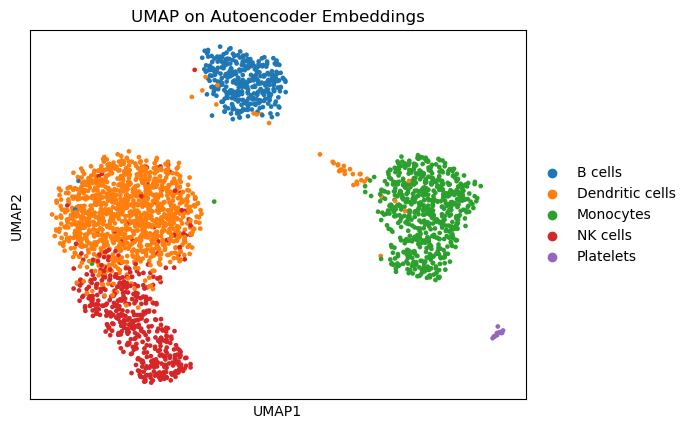

In [31]:
sc.pp.neighbors(adata, use_rep='X_ae', n_neighbors=10)
sc.tl.umap(adata)
sc.pl.umap(adata, color='cell_type', title='UMAP on Autoencoder Embeddings')

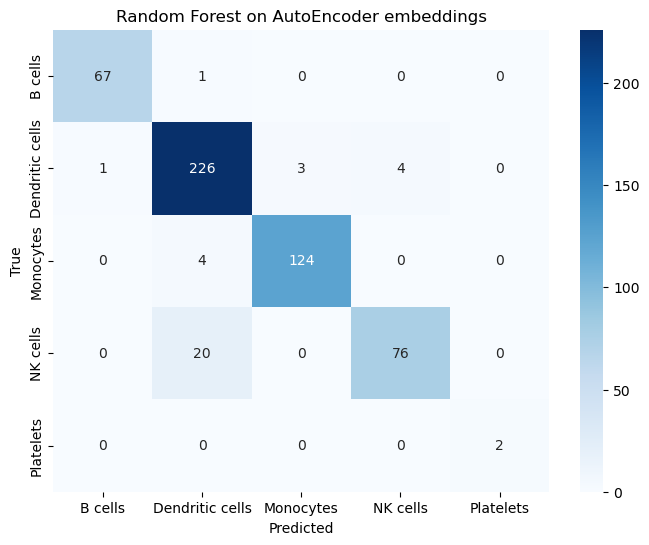

In [32]:
# Recreate X_train_emb, X_test_emb aligned with previous split:
X_emb_train, X_emb_test, y_train_emb, y_test_emb = train_test_split(embeddings, y, test_size=0.2, random_state=42, stratify=y)

rf_emb = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
rf_emb.fit(X_emb_train, y_train_emb)
y_pred_rf_emb = rf_emb.predict(X_emb_test)

plot_cm(confusion_matrix(y_test_emb, y_pred_rf_emb, labels=class_names), class_names, "Random Forest on AutoEncoder embeddings")